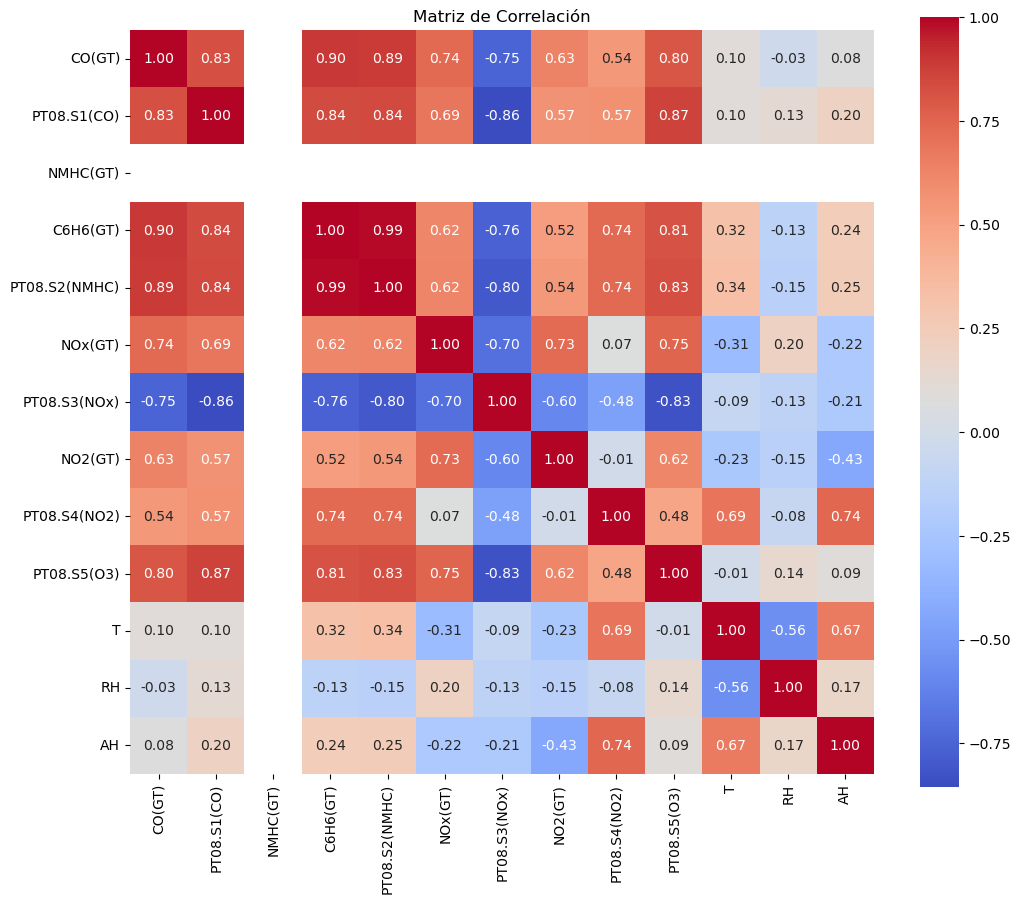

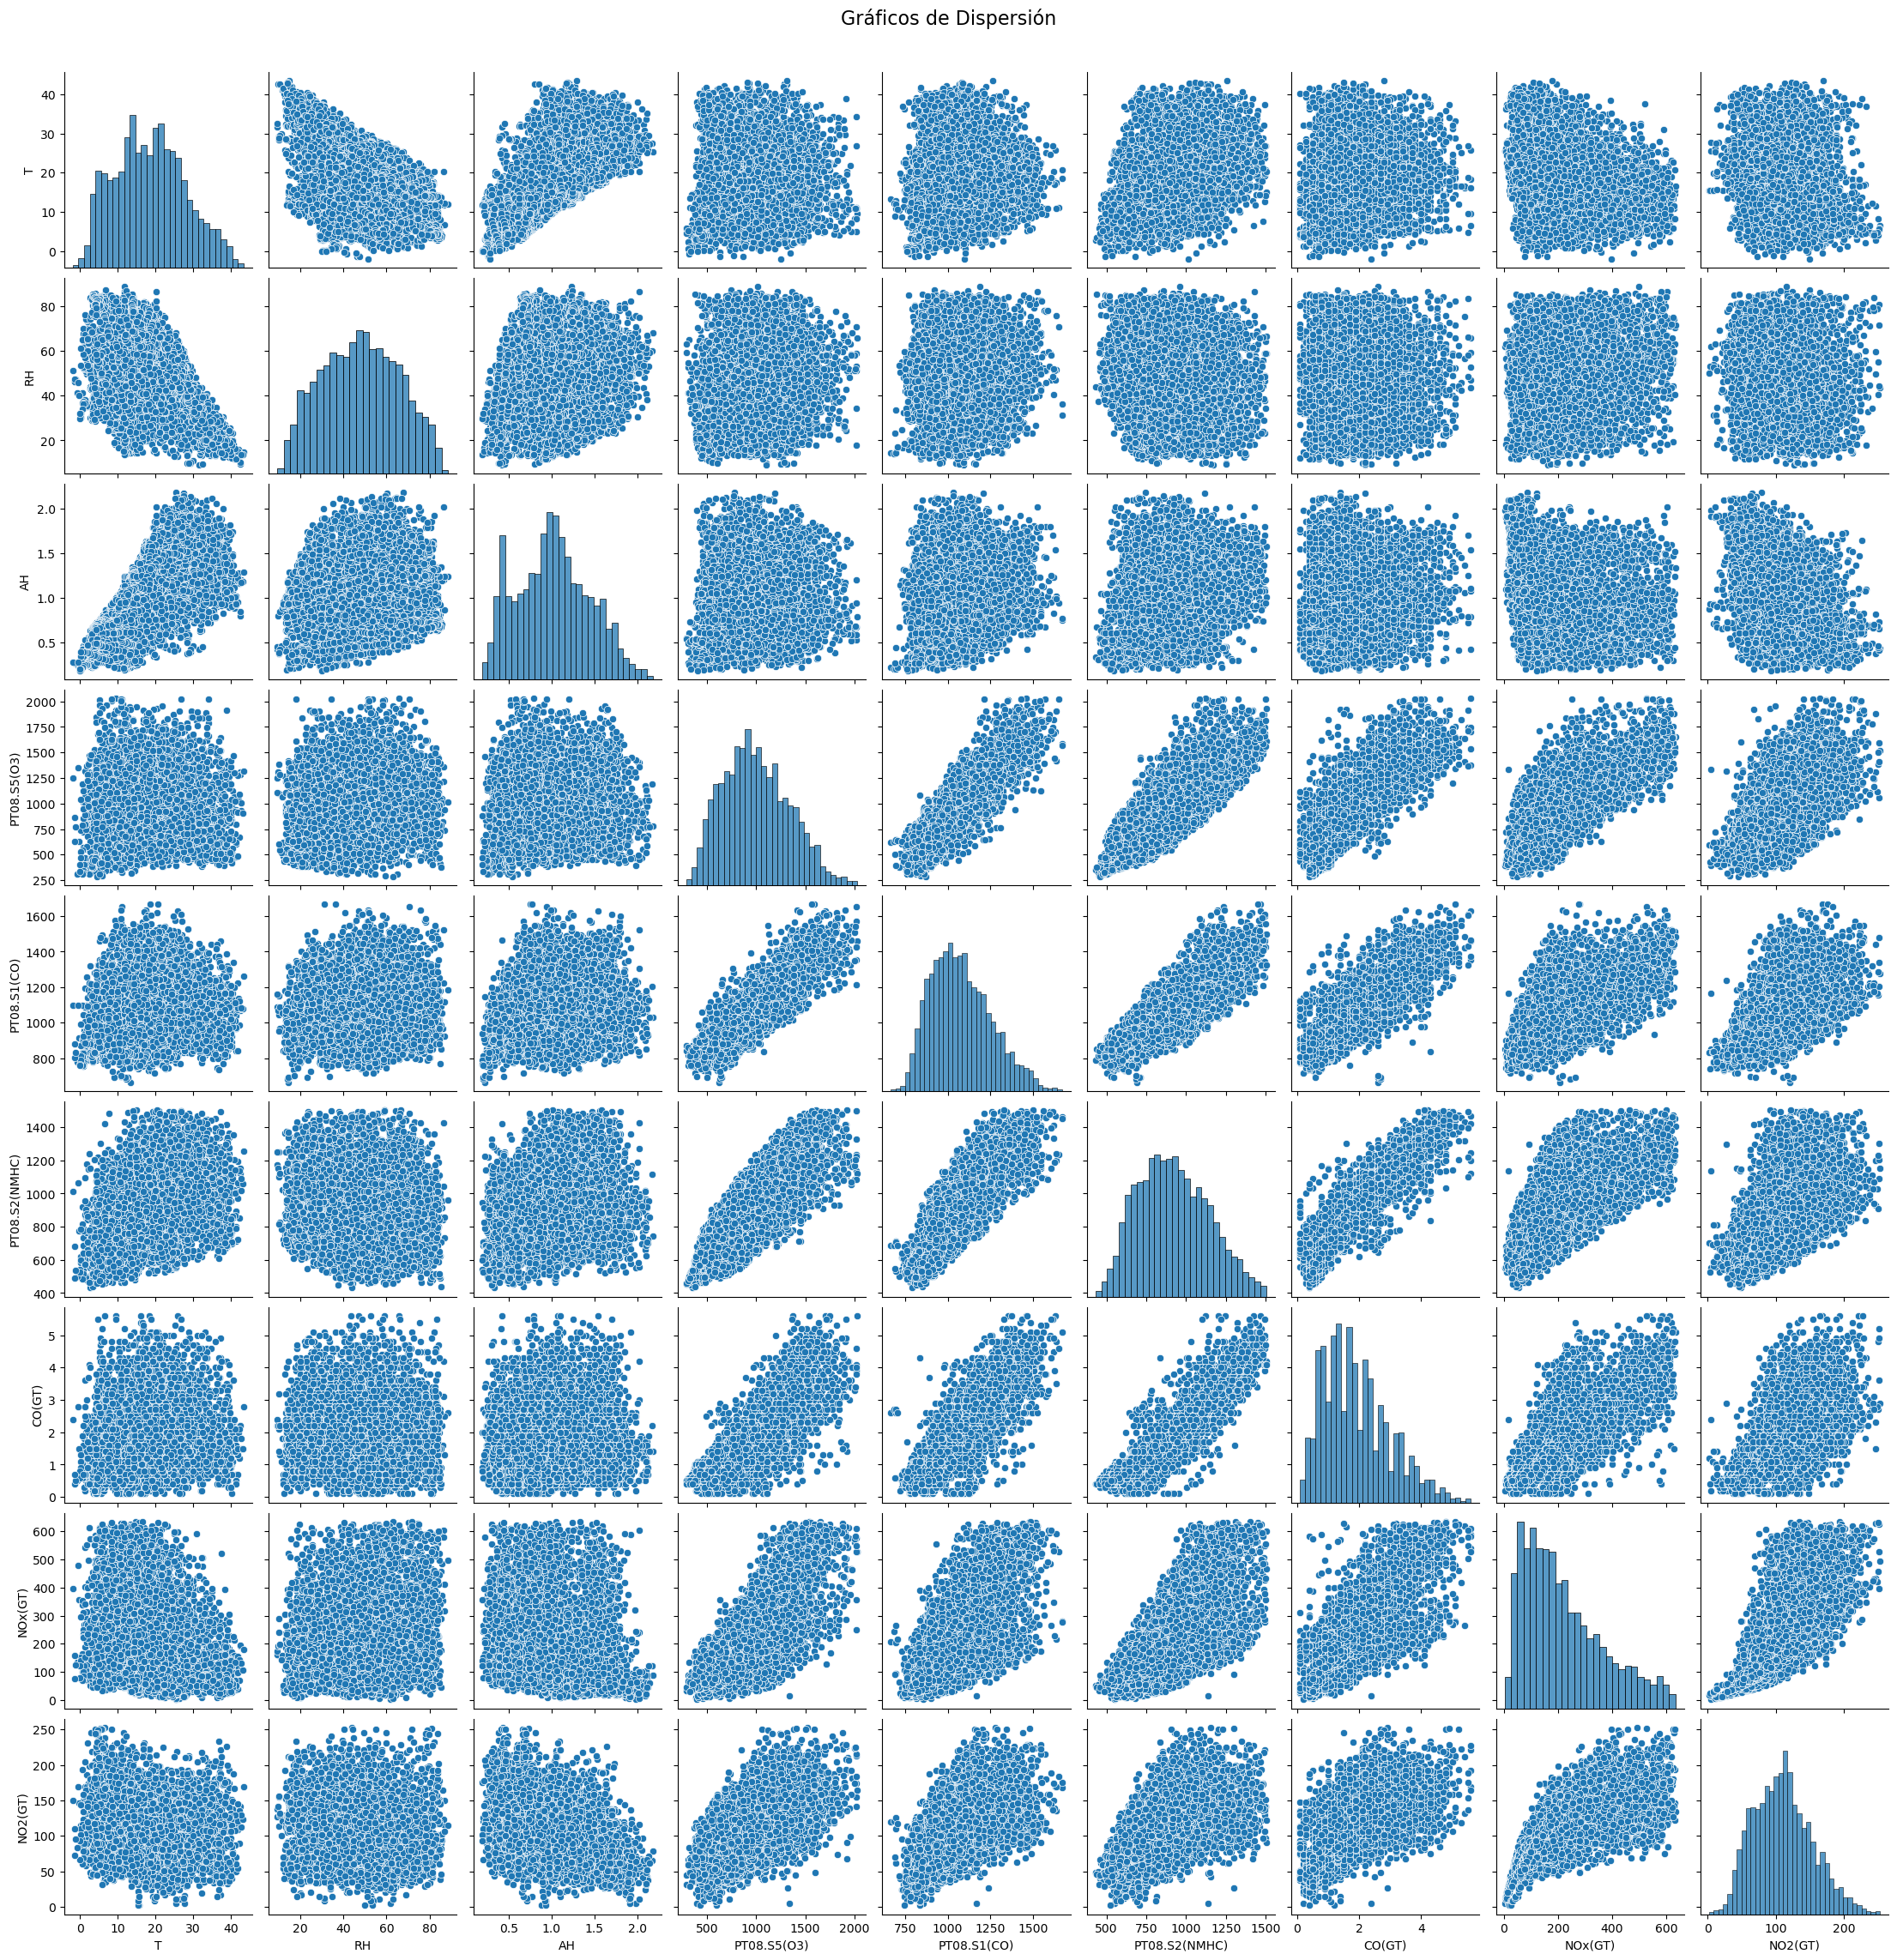


Entrenando modelos para el objetivo: CO(GT)

Entrenando modelos para el objetivo: NOx(GT)

Entrenando modelos para el objetivo: NO2(GT)

Resultados para CO(GT):
Linear Regression: MSE = 0.1669, R2 = 0.8616
Decision Tree: MSE = 0.2624, R2 = 0.7824
Random Forest: MSE = 0.1364, R2 = 0.8869
Gradient Boosting: MSE = 0.1439, R2 = 0.8807
Support Vector Regressor: MSE = 0.1431, R2 = 0.8813

Resultados para NOx(GT):
Linear Regression: MSE = 6421.2106, R2 = 0.7126
Decision Tree: MSE = 7815.8253, R2 = 0.6502
Random Forest: MSE = 4101.1522, R2 = 0.8164
Gradient Boosting: MSE = 4581.7302, R2 = 0.7949
Support Vector Regressor: MSE = 7187.5694, R2 = 0.6783

Resultados para NO2(GT):
Linear Regression: MSE = 606.6092, R2 = 0.6863
Decision Tree: MSE = 669.4895, R2 = 0.6538
Random Forest: MSE = 355.6437, R2 = 0.8161
Gradient Boosting: MSE = 413.5267, R2 = 0.7862
Support Vector Regressor: MSE = 492.1943, R2 = 0.7455


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Cargar el dataset
file_path = 'data/AirQuality2.csv'
df = pd.read_csv(file_path, sep=',')

# Reemplazar comas por puntos y convertir columnas a numérico
df = df.replace(',', '.', regex=True)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Eliminar columnas innecesarias
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16', 'Date', 'Time'], errors='ignore')

# Eliminar filas con valores faltantes
df_cleaned = df.dropna()

# Identificar y eliminar outliers usando el método IQR
Q1 = df_cleaned.quantile(0.25)
Q3 = df_cleaned.quantile(0.75)
IQR = Q3 - Q1
df_no_outliers = df_cleaned[~((df_cleaned < (Q1 - 1.5 * IQR)) | (df_cleaned > (Q3 + 1.5 * IQR))).any(axis=1)]

# Matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(df_no_outliers.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación")
plt.show()

# Gráficos de dispersión
predictors = ['T', 'RH', 'AH', 'PT08.S5(O3)', 'PT08.S1(CO)', 'PT08.S2(NMHC)']
targets = ['CO(GT)', 'NOx(GT)', 'NO2(GT)']
sns.pairplot(df_no_outliers, vars=predictors + targets, height=2.5)
plt.suptitle("Gráficos de Dispersión", y=1.02, fontsize=16)
plt.show()

# Separar datos en entrenamiento y validación
X = df_no_outliers[predictors]
y = df_no_outliers[targets]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entrenar modelos
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Regressor': SVR()
}

results = {}

# Entrenar y evaluar cada modelo por variable objetivo
for target in targets:
    print(f"\nEntrenando modelos para el objetivo: {target}")
    y_train_target = y_train[target]
    y_test_target = y_test[target]
    
    results[target] = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train_target)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test_target, y_pred)
        r2 = r2_score(y_test_target, y_pred)
        results[target][name] = {'MSE': mse, 'R2': r2}

# Mostrar resultados
for target, metrics in results.items():
    print(f"\nResultados para {target}:")
    for name, scores in metrics.items():
        print(f"{name}: MSE = {scores['MSE']:.4f}, R2 = {scores['R2']:.4f}")



In [20]:


import joblib
joblib.dump(models, 'modelo_xgb_optimizado.pkl')

['modelo_xgb_optimizado.pkl']

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, make_scorer
import warnings
warnings.filterwarnings('ignore')
# lectura del csv con ';' como separador
path = 'data/AirQuality.csv'
df = pd.read_csv(path, sep=';')

# si deseas guardar el DataFrame con ',' como separador
output_path = 'data/AirQuality2.csv'
df.to_csv(output_path, index=False, sep=',')  # Guardar con ',' como separador

#exploración de los datos 
df.info()

df.describe()

df.head(30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  \
0   10/03/2004  18.00.00    2,6       1360.0     150.0     11,9   
1   10/03/2004  19.00.00      2       1292.0     112.0      9,4   
2   10/03/2004  20.00.00    2,2       1402.0      88.0      9,0   
3   10/03/2004  21.00.00    2,2       1376.0      80.0      9,2   
4   10/03/2004  22.00.00    1,6       1272.0      51.0      6,5   
5   10/03/2004  23.00.00    1,2       1197.0      38.0      4,7   
6   11/03/2004  00.00.00    1,2       1185.0      31.0      3,6   
7   11/03/2004  01.00.00      1       1136.0      31.0      3,3   
8   11/03/2004  02.00.00    0,9       1094.0      24.0      2,3   
9   11/03/2004  03.00.00    0,6       1010.0      19.0      1,7   
10  11/03/2004  04.00.00   -200       1011.0      14.0      1,3   
11  11/03/2004  05.00.00    0,7       1066.0       8.0      1,1   
12  11/03/2004  06.00.00    0,7       1052.0      16.0      1,6   
13  11/03/2004  07.00.00    1,1       1144.0      29.0      3,2   
14  11/03/2004  08.00.00      2       1333.0      64.0      8,0   
15  11/03/2004  09.00.00    2,2       1351.0      87.0      9,5   
16  11/03/2004  10.00.00    1,7       1233.0      77.0      6,3   
17  11/03/2004  11.00.00    1,5       1179.0      43.0      5,0   
18  11/03/2004  12.00.00    1,6       1236.0      61.0      5,2   
19  11/03/2004  13.00.00    1,9       1286.0      63.0      7,3   
20  11/03/2004  14.00.00    2,9       1371.0     164.0     11,5   
21  11/03/2004  15.00.00    2,2       1310.0      79.0      8,8   
22  11/03/2004  16.00.00    2,2       1292.0      95.0      8,3   
23  11/03/2004  17.00.00    2,9       1383.0     150.0     11,2   
24  11/03/2004  18.00.00    4,8       1581.0     307.0     20,8   
25  11/03/2004  19.00.00    6,9       1776.0     461.0     27,4   
26  11/03/2004  20.00.00    6,1       1640.0     401.0     24,0   
27  11/03/2004  21.00.00    3,9       1313.0     197.0     12,8   
28  11/03/2004  22.00.00    1,5        965.0      61.0      4,7   
29  11/03/2004  23.00.00      1        913.0      26.0      2,6   

    PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0          1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1           955.0    103.0        1174.0     92.0        1559.0        972.0   
2           939.0    131.0        1140.0    114.0        1555.0       1074.0   
3           948.0    172.0        1092.0    122.0        1584.0       1203.0   
4           836.0    131.0        1205.0    116.0        1490.0       1110.0   
5           750.0     89.0        1337.0     96.0        1393.0        949.0   
6           690.0     62.0        1462.0     77.0        1333.0        733.0   
7           672.0     62.0        1453.0     76.0        1333.0        730.0   
8           609.0     45.0        1579.0     60.0        1276.0        620.0   
9           561.0   -200.0        1705.0   -200.0        1235.0        501.0   
10          527.0     21.0        1818.0     34.0        1197.0        445.0   
11          512.0     16.0        1918.0     28.0        1182.0        422.0   
12          553.0     34.0        1738.0     48.0        1221.0        472.0   
13          667.0     98.0        1490.0     82.0        1339.0        730.0   
14          900.0    174.0        1136.0    112.0        1517.0       1102.0   
15          960.0    129.0        1079.0    101.0        1583.0       1028.0   
16          827.0    112.0        1218.0     98.0        1446.0        860.0   
17          762.0     95.0        1328.0     92.0        1362.0        671.0   
18          774.0    104.0        1301.0     95.0        1401.0        664.0   
19          869.0    146.0        1162.0    112.0        1537.0        799.0   
20         1034.0    207.0         983.0    128.0        1730.0       1037.0   
21          933.0    184.0        1082.0    126.0        1647.0        946.0   
22          912.0    193.0        1103.0    131.0        1591.0        957.0   
23         1

In [2]:
# Identificar valores faltantes
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_summary = pd.DataFrame({
    'Valores Faltantes': missing_values,
    'Porcentaje Faltante': missing_percentage
})

# Eliminar columnas específicas
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'])

# Verificar si las columnas fueron eliminadas
print("Columnas después de eliminar 'Unnamed: 15' y 'Unnamed: 16':")
print(df.columns)



Columnas después de eliminar 'Unnamed: 15' y 'Unnamed: 16':
Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')


In [3]:
# Eliminar filas con valores faltantes
df_cleaned = df.dropna()

# Verificar si todavía hay valores faltantes
print("Después de eliminar filas con valores faltantes:")
print(df_cleaned.isnull().sum())


Después de eliminar filas con valores faltantes:
Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


In [4]:
# Análisis de outliers utilizando IQR
def detect_outliers_iqr(df_cleaned, column):
    if df_cleaned[column].dtype in ['float64', 'int64']:
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return df_cleaned[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)]
    else:
        return pd.DataFrame()

outliers_detected = {col: len(detect_outliers_iqr(df_cleaned, col)) for col in df_cleaned.select_dtypes(include=['float64']).columns}

print("\nOutliers Detectados por Columna:")
for col, count in outliers_detected.items():
    print(f"{col}: {count} outliers")



Outliers Detectados por Columna:
PT08.S1(CO): 484 outliers
NMHC(GT): 914 outliers
PT08.S2(NMHC): 426 outliers
NOx(GT): 509 outliers
PT08.S3(NOx): 602 outliers
NO2(GT): 1696 outliers
PT08.S4(NO2): 450 outliers
PT08.S5(O3): 458 outliers


In [5]:
# Seleccionar solo las columnas numéricas para calcular la matriz de correlación
numeric_columns = df_cleaned.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_columns.corr()

print("\nMatriz de Correlación:")
print(correlation_matrix)


Matriz de Correlación:
               PT08.S1(CO)  NMHC(GT)  PT08.S2(NMHC)   NOx(GT)  PT08.S3(NOx)  \
PT08.S1(CO)       1.000000  0.170007       0.933102  0.277993      0.087019   
NMHC(GT)          0.170007  1.000000       0.110104 -0.004427      0.048821   
PT08.S2(NMHC)     0.933102  0.110104       1.000000  0.331272     -0.073667   
NOx(GT)           0.277993 -0.004427       0.331272  1.000000     -0.436084   
PT08.S3(NOx)      0.087019  0.048821      -0.073667 -0.436084      1.000000   
NO2(GT)           0.154030  0.103307       0.176488  0.817139     -0.256232   
PT08.S4(NO2)      0.845149  0.162680       0.874782  0.035546      0.122734   
PT08.S5(O3)       0.892434  0.101185       0.909905  0.461889     -0.208865   

                NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  
PT08.S1(CO)    0.154030      0.845149     0.892434  
NMHC(GT)       0.103307      0.162680     0.101185  
PT08.S2(NMHC)  0.176488      0.874782     0.909905  
NOx(GT)        0.817139      0.035546     0.461889  

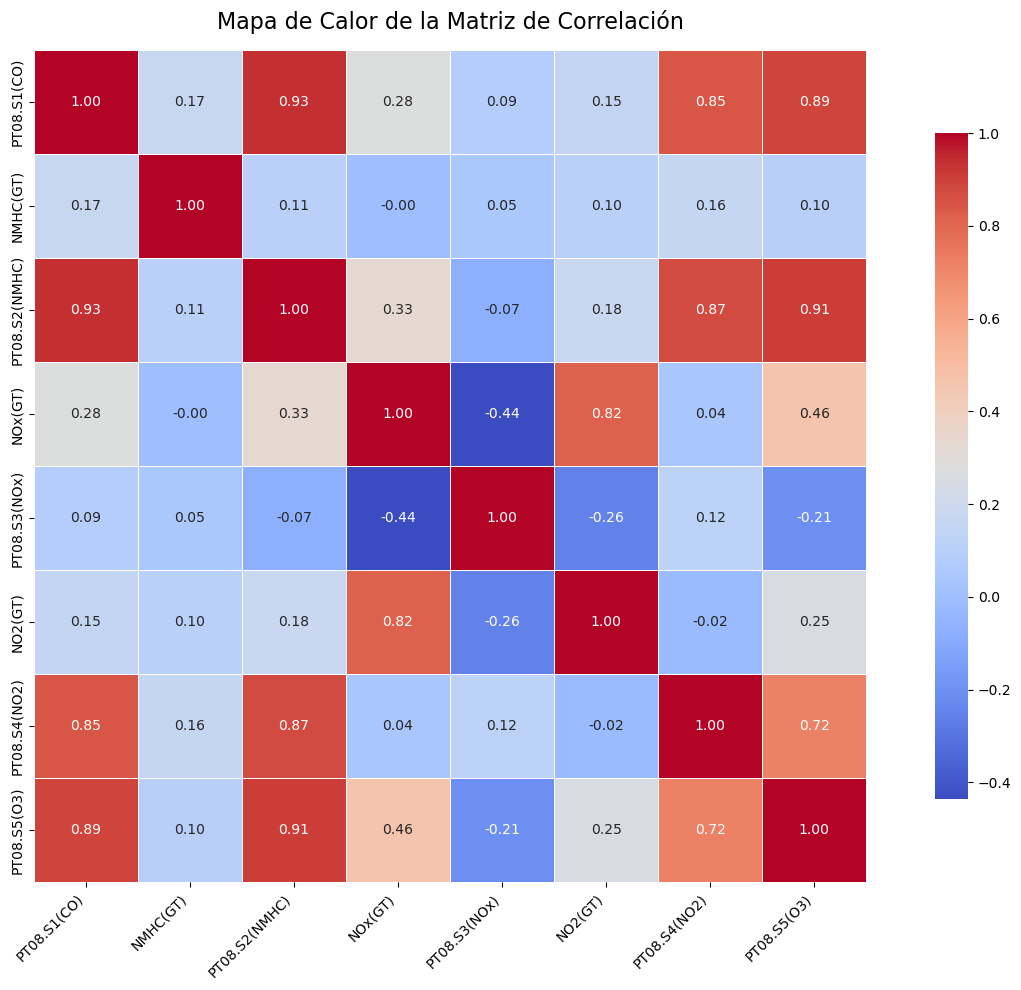

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar solo las columnas numéricas
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
correlation_matrix = numeric_columns.corr()

# Crear el mapa de calor
plt.figure(figsize=(14, 10))  # Aumentar el tamaño de la figura
sns.heatmap(
    correlation_matrix,
    annot=True,                # Mostrar los valores dentro del mapa
    fmt=".2f",                 # Formato de los números
    cmap="coolwarm",           # Paleta de colores
    square=True,               # Asegurar celdas cuadradas
    cbar_kws={'shrink': 0.8},  # Reducir tamaño de la barra de color
    linewidths=0.5,            # Añadir bordes finos entre celdas
    annot_kws={"size": 10}     # Tamaño de la fuente en anotaciones
)

# Personalización adicional
plt.title("Mapa de Calor de la Matriz de Correlación", fontsize=16, pad=15)  # Título con tamaño ajustado
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotar etiquetas en el eje X
plt.yticks(fontsize=10)  # Ajustar tamaño de etiquetas en el eje Y
plt.tight_layout()  # Ajustar para evitar recortes

# Mostrar el mapa
plt.show()


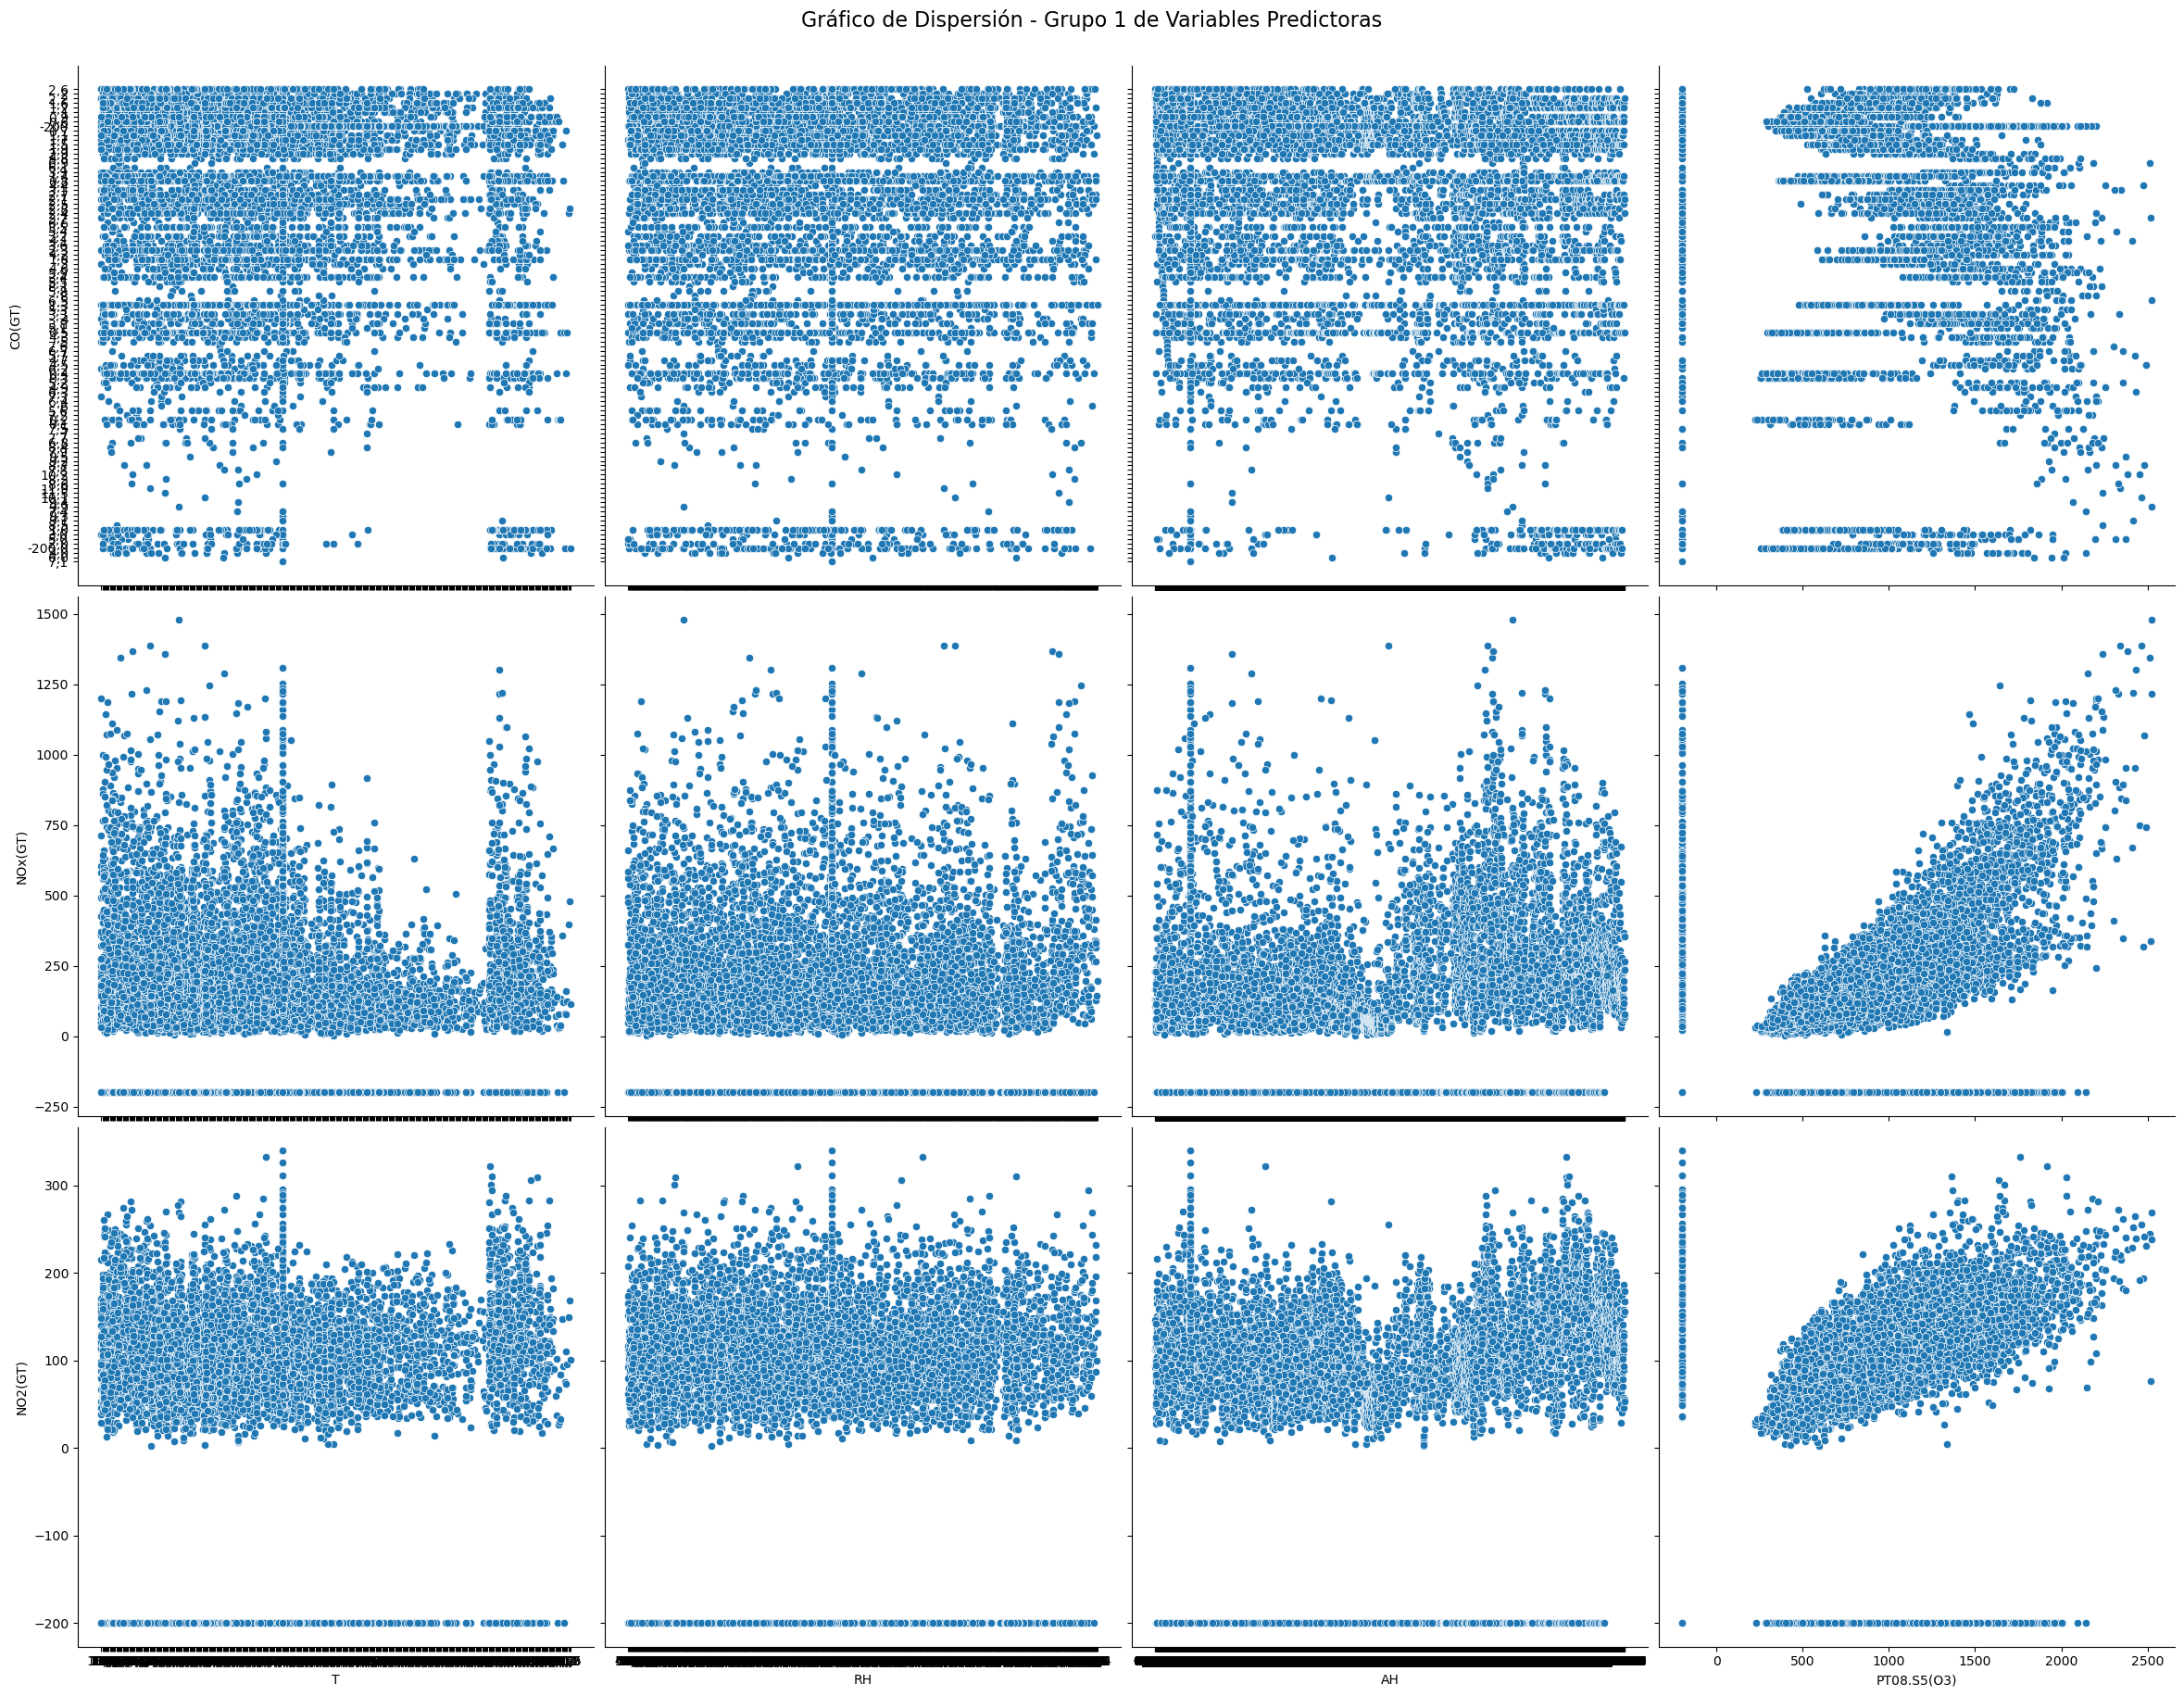

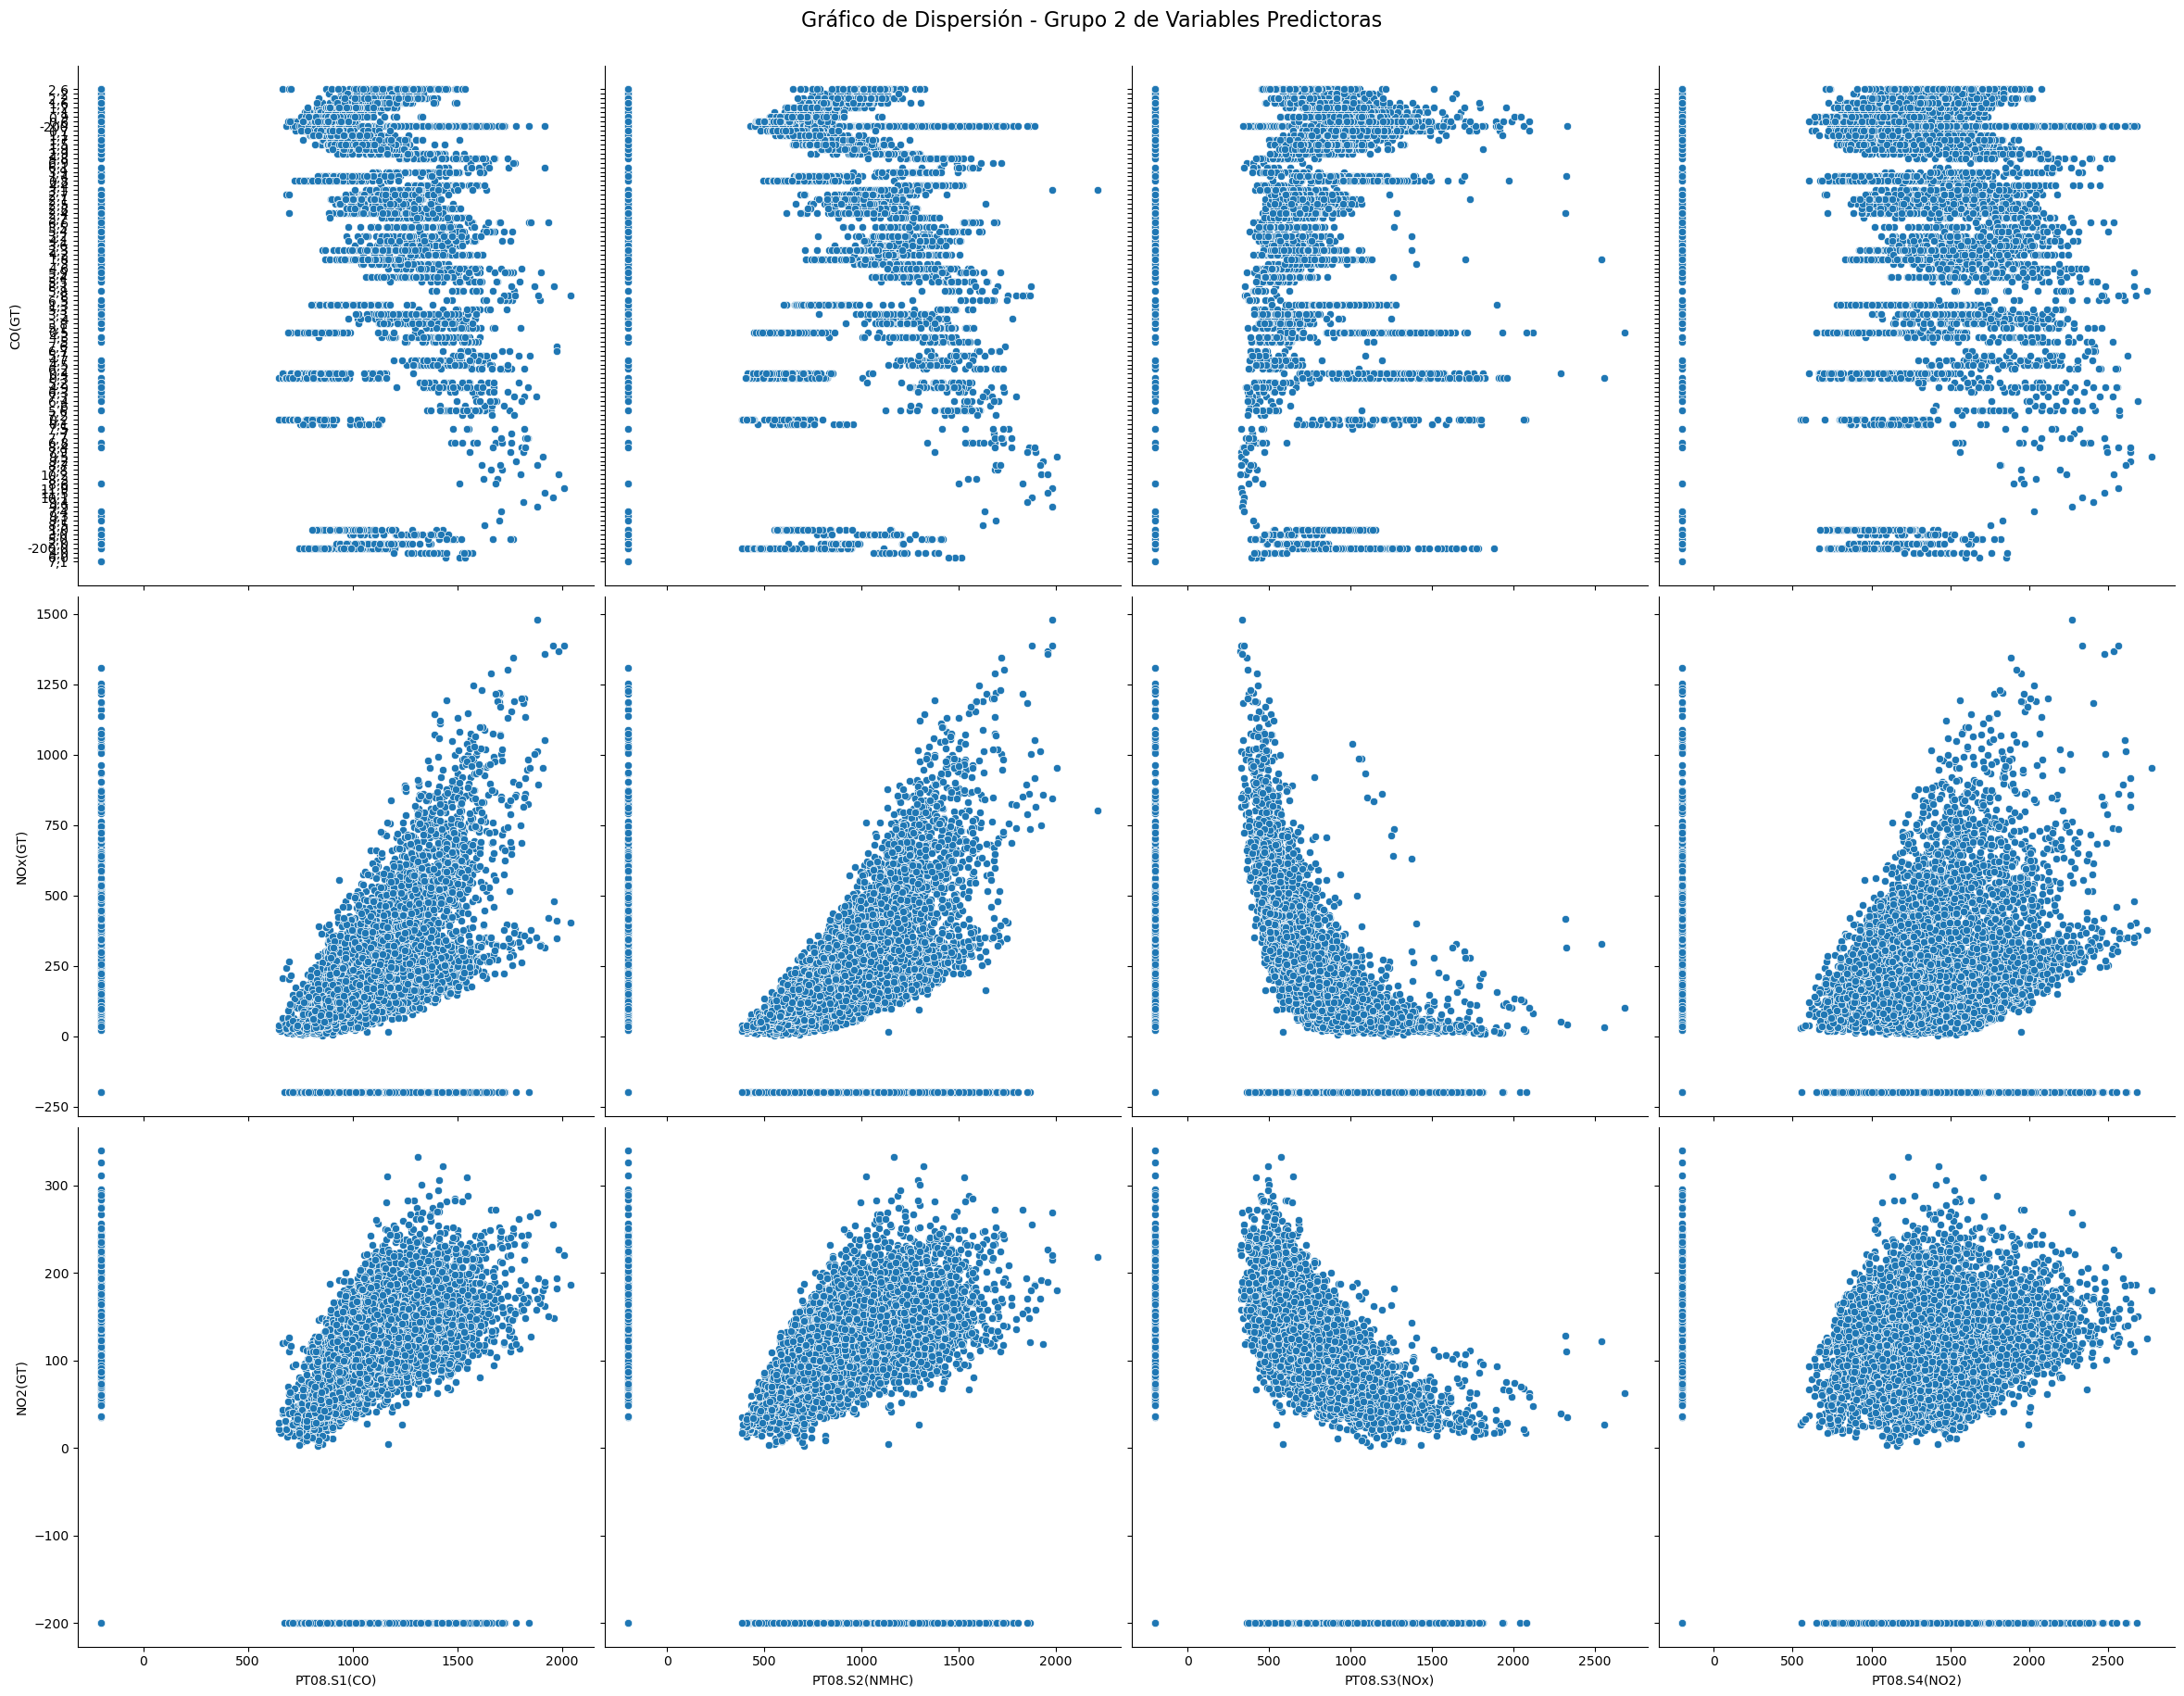

In [7]:

# Seleccionar las columnas correspondientes del dataset
# Ajusta estas listas según las columnas específicas de tu dataset
predictors_group1 = ['T', 'RH', 'AH', 'PT08.S5(O3)']  # Ejemplo de variables predictoras grupo 1
predictors_group2 = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)']  # Grupo 2
targets = ['CO(GT)', 'NOx(GT)', 'NO2(GT)']  # Contaminantes

# Grupo 1 de variables predictoras
sns.pairplot(df_cleaned, 
             x_vars=predictors_group1,  # Primer grupo de variables predictoras
             y_vars=targets,            # Variables objetivo
             height=6, 
             aspect=1, 
             kind='scatter')
plt.suptitle("Gráfico de Dispersión - Grupo 1 de Variables Predictoras", y=1.02, fontsize=16)
plt.show()

# Grupo 2 de variables predictoras
sns.pairplot(df_cleaned, 
             x_vars=predictors_group2,  # Segundo grupo de variables predictoras
             y_vars=targets,            # Variables objetivo
             height=6, 
             aspect=1, 
             kind='scatter')
plt.suptitle("Gráfico de Dispersión - Grupo 2 de Variables Predictoras", y=1.02, fontsize=16)
plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Asegurar que todas las columnas tengan valores numéricos correctamente formateados
df_cleaned = df_cleaned.replace(',', '.', regex=True)

# Seleccionar las variables predictoras
predictor_columns = ['T', 'RH', 'AH', 'PT08.S5(O3)', 
                     'PT08.S1(CO)', 'PT08.S2(NMHC)', 
                     'PT08.S3(NOx)', 'PT08.S4(NO2)']

# Validar que las columnas existen
predictor_columns = [col for col in predictor_columns if col in df_cleaned.columns]

# Convertir las columnas seleccionadas a tipo numérico
for column in predictor_columns:
    df_cleaned[column] = pd.to_numeric(df_cleaned[column], errors='coerce')

# Normalizar las variables predictoras
scaler = MinMaxScaler()
X = df_cleaned[predictor_columns]
X_scaled = scaler.fit_transform(X)

# Definir las variables objetivo
target_columns = ['CO(GT)', 'NOx(GT)', 'NO2(GT)']
target_columns = [col for col in target_columns if col in df_cleaned.columns]

# Convertir las variables objetivo a tipo numérico
for column in target_columns:
    df_cleaned[column] = pd.to_numeric(df_cleaned[column], errors='coerce')
y = df_cleaned[target_columns]

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Verificar las formas de los conjuntos de datos resultantes
print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_test:", y_test.shape)


Forma de X_train: (7485, 8)
Forma de X_test: (1872, 8)
Forma de y_train: (7485, 3)
Forma de y_test: (1872, 3)


In [9]:
# Crear un scorer para RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Definir los hiperparámetros de los modelos
parametros = {
    'Regresión Lineal': {},  # Sin hiperparámetros clave
    'Árbol de Decisión': {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 10]
    },
    'Red Neuronal': {
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
}

# Modelos a optimizar
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Red Neuronal': MLPRegressor(max_iter=1000, random_state=42)
}

# TimeSeriesSplit para validación cruzada
tscv = TimeSeriesSplit(n_splits=5)

# Optimización de hiperparámetros y almacenamiento de los mejores modelos
mejores_modelos = {}
for nombre, modelo in modelos.items():
    print(f"\nOptimizando {nombre}...")
    if parametros[nombre]:  # Si hay hiperparámetros definidos
        grid_search = GridSearchCV(estimator=modelo, param_grid=parametros[nombre], scoring=rmse_scorer, cv=tscv, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        mejores_modelos[nombre] = grid_search.best_estimator_
        print(f"Mejores parámetros para {nombre}: {grid_search.best_params_}")
    else:
        modelo.fit(X_train, y_train)
        mejores_modelos[nombre] = modelo
        print(f"{nombre} no requiere optimización de hiperparámetros.")


Optimizando Regresión Lineal...
Regresión Lineal no requiere optimización de hiperparámetros.

Optimizando Árbol de Decisión...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores parámetros para Árbol de Decisión: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}

Optimizando Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros para Random Forest: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

Optimizando XGBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores parámetros para XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}

Optimizando Red Neuronal...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores parámetros para Red Neuronal: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}



Evaluando Regresión Lineal...

Evaluando Árbol de Decisión...

Evaluando Random Forest...

Evaluando XGBoost...

Evaluando Red Neuronal...

Resultados:
              Modelo  MAE Promedio  MSE Promedio  RMSE Promedio  R2 Promedio  \
0   Regresión Lineal     26.212250   2183.140460      33.901677     0.750555   
1  Árbol de Decisión     26.539822   2741.555710      38.294048     0.642901   
2      Random Forest     24.005155   1852.876920      31.944444     0.735396   
3            XGBoost     62.309303   7536.811147      76.806398 -1290.160620   
4       Red Neuronal     20.951276   1500.162000      28.645799     0.787183   

   Varianza Explicada  
0            0.751025  
1            0.643420  
2            0.735756  
3            0.266828  
4            0.788543  


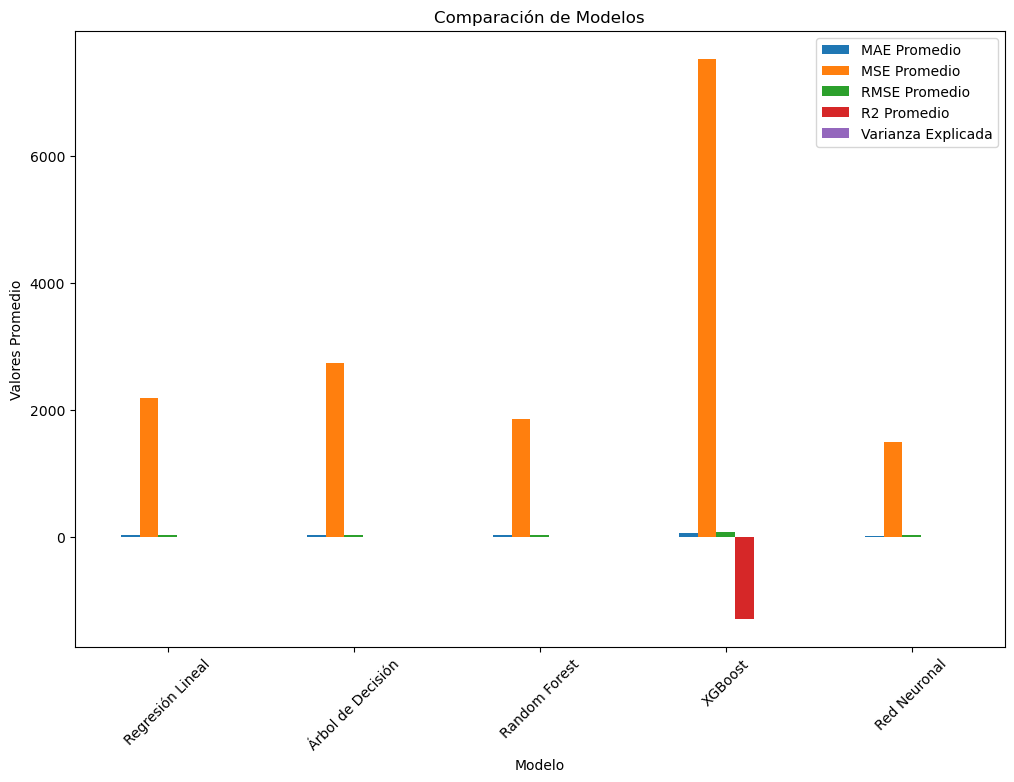

In [19]:
# Crear scorers personalizados para las métricas
scorers = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'R2': make_scorer(r2_score),
    'Explained Variance': make_scorer(explained_variance_score)
}

# Evaluar los modelos con validación cruzada
resultados = []
for nombre, modelo in mejores_modelos.items():
    print(f"\nEvaluando {nombre}...")
    scores = cross_validate(modelo, X_train, y_train, cv=5, scoring=scorers)
    resultados.append({
        'Modelo': nombre,
        'MAE Promedio': scores['test_MAE'].mean(),
        'MSE Promedio': scores['test_MSE'].mean(),
        'RMSE Promedio': scores['test_RMSE'].mean(),
        'R2 Promedio': scores['test_R2'].mean(),
        'Varianza Explicada': scores['test_Explained Variance'].mean()
    })

# Mostrar resultados
resultados_df = pd.DataFrame(resultados)
print("\nResultados:")
print(resultados_df)

# Visualizar resultados
resultados_df.set_index('Modelo', inplace=True)
resultados_df.plot(kind='bar', figsize=(12, 8), title='Comparación de Modelos')
plt.ylabel('Valores Promedio')
plt.xticks(rotation=45)
plt.show()


import joblib
joblib.dump(xgb_optimized, 'modelo_xgb_optimizado.pkl')